In [ ]:
import pandas as pd


# Load the data
df = pd.read_csv('../../data/clustered_df.csv', sep = ',')

print(df.head())

   Rank                            Title  \
0   128            Romantic - NOTD Remix   
1   156                           Bubalu   
2   108   Redemption (with Babes Wodumo)   
3    32  WAP (feat. Megan Thee Stallion)   
4    15                          bad guy   

                                             Artists        Date  \
0                                             Stanaj  2017-01-24   
1  Becky G, Prince Royce, DJ Luian, Mambo Kingz, ...  2019-03-31   
2                                             Zacari  2018-02-09   
3                                            Cardi B  2021-02-05   
4                                      Billie Eilish  2019-11-21   

   Danceability    Energy  Loudness  Speechiness  Acousticness  \
0      0.417042 -0.040277 -0.858544     1.256145     -0.083190   
1      0.808061 -1.758788  1.915108    -0.183260      1.557062   
2      0.677722  0.775394 -0.570984    -0.132218     -0.408768   
3      1.785610 -1.142366 -0.698556     2.726176     -0.903316

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Data loading and feature setting
feature_columns = ["Danceability", "Energy", "Loudness", "Speechiness", "Acousticness", "Instrumentalness", "Valence"]
score_column = "Points (Total)"
date_column = "Date"

# Normalizing features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[feature_columns])

# KMeans 
n_clusters = 4  # The optimal number of clusters we obtained



In [3]:

print(f"Original DataFrame rows: {df.shape[0]}")
print(f"Scaled data rows: {scaled_data.shape[0]}")

# Handling missing values
df[feature_columns] = df[feature_columns].fillna(0)

# Re standardize
scaled_data = scaler.fit_transform(df[feature_columns])



# Calculate feature mean by genre
cluster_means = df.groupby('Predicted_Genre')[feature_columns].mean()
global_means = df[feature_columns].mean()

# Compare the feature mean of each genre with the global mean
cluster_descriptions = {}
for cluster in range(n_clusters):
    cluster_diff = cluster_means.loc[cluster] - global_means
    sorted_diff = cluster_diff.abs().sort_values(ascending=False)  
    significant_features = sorted_diff.head(3).index 
    cluster_descriptions[cluster] = {
        feature: f"{'High' if cluster_diff[feature] > 0 else 'Low'}"
        for feature in significant_features
    }

# Output characteristic descriptions for each genre
print("Characteristic descriptions：")
for cluster, description in cluster_descriptions.items():
    print(f"Genre {cluster}:")
    for feature, value in description.items():
        print(f"  {feature}: {value}")



Original DataFrame rows: 470436
Scaled data rows: 470436
Characteristic descriptions：
Genre 0:
  Speechiness: High
  Danceability: High
  Loudness: Low
Genre 1:
  Energy: Low
  Acousticness: High
  Danceability: Low
Genre 2:
  Instrumentalness: High
  Loudness: Low
  Valence: Low
Genre 3:
  Energy: High
  Loudness: High
  Valence: High


In [4]:
df = df.rename(columns={'Predicted_Genre': 'Predicted_Genre'})
genre_mapping = {
    0: 'Hip-Hop / Rap',
    1: 'Folk / Acoustic Ballads',
    2: 'Ambient / Classical',
    3: 'Pop / Dance / Electronic'
}
df['Predicted_Genre'] = df['Predicted_Genre'].replace(genre_mapping)

In [5]:
# Add time features
df['YearMonth'] = pd.to_datetime(df['Date']).dt.to_period('M')
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Quarter'] = pd.to_datetime(df['Date']).dt.quarter
df['Year'] = pd.to_datetime(df['Date']).dt.year


# Calculate the monthly average score for each Genre
monthly_data = (
    df.groupby(['Predicted_Genre', 'YearMonth'])  # Group by Genre and YearMonth
      .agg({
          'Points (Total)': 'mean',             # Calculate the average score on a monthly basis
          **{col: 'mean' for col in feature_columns},  # Take the mean of the feature column
          'Month': 'first',                     # Time feature
          'Quarter': 'first',
          'Year': 'first'
      })
      .reset_index()
)
# Convert YearMonth to timestamp format for easy drawing and model usage
monthly_data['YearMonth'] = monthly_data['YearMonth'].dt.to_timestamp()

print("Monthly data range:", monthly_data['YearMonth'].min(), "-", monthly_data['YearMonth'].max())


Monthly data range: 2017-01-01 00:00:00 - 2023-05-01 00:00:00


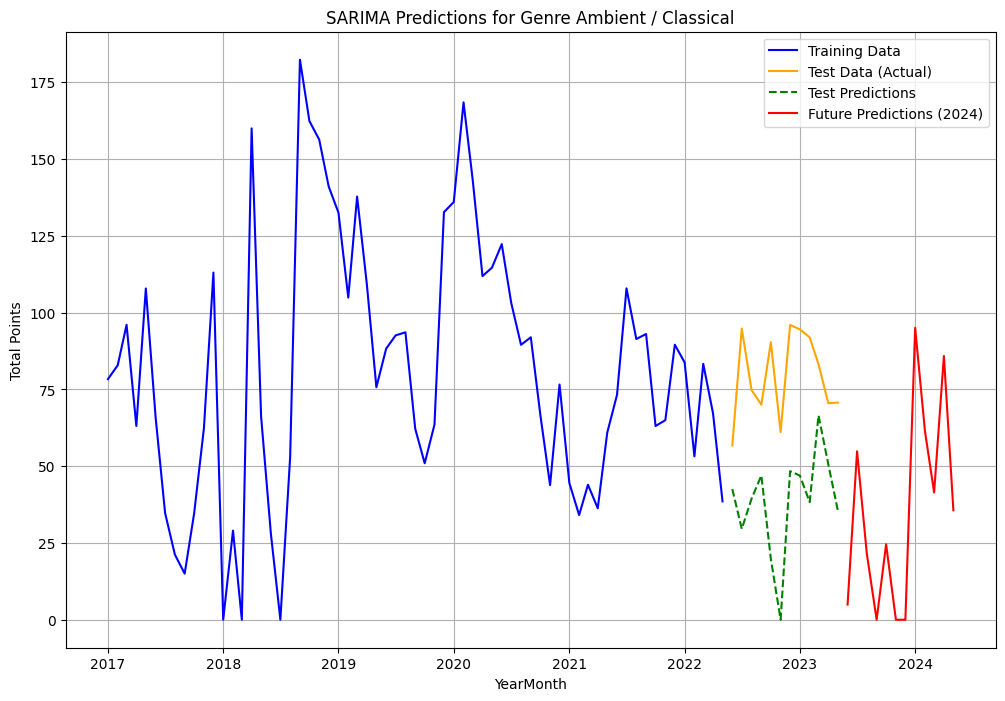

c:\Users\86137\anaconda3\envs\pytorch\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


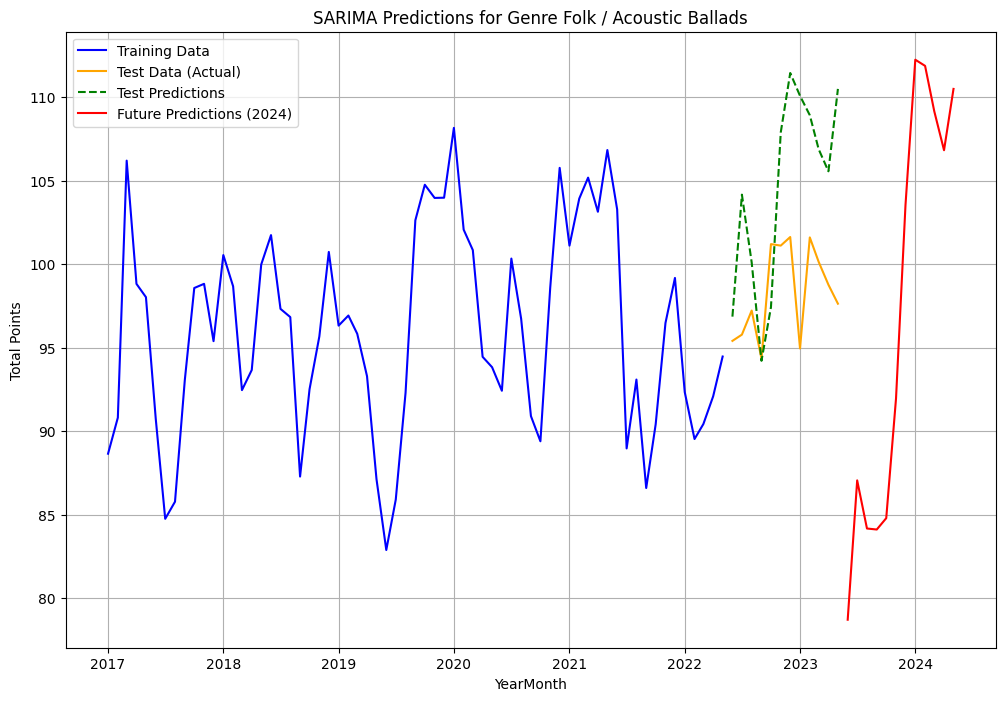

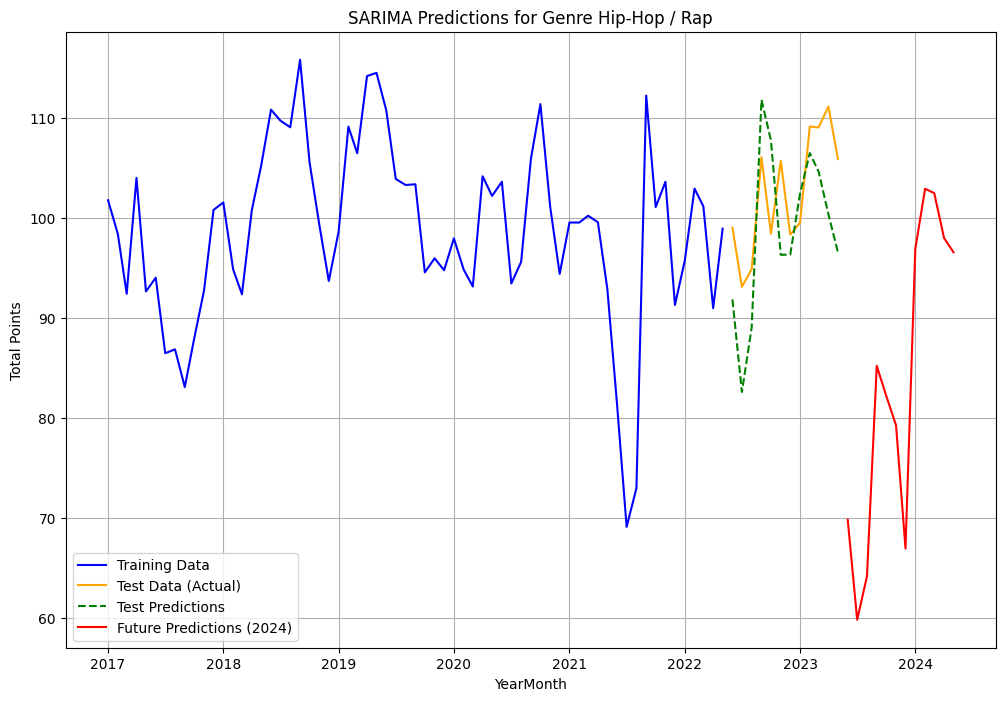

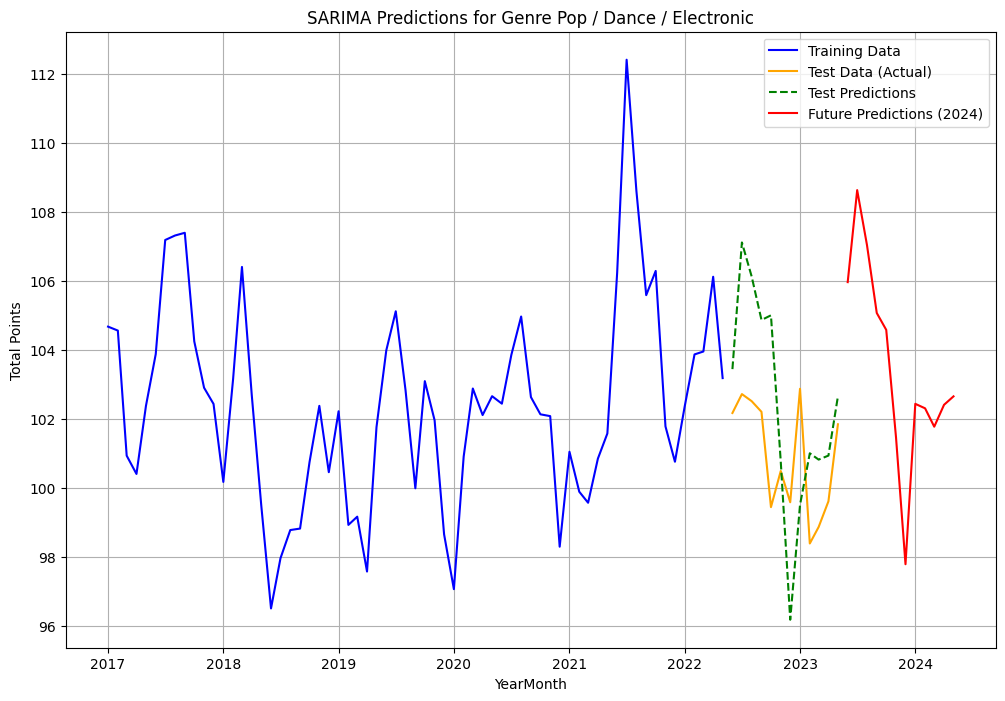

2024年各流派的总得分：
Predicted_Genre
Ambient / Classical          425.161155
Folk / Acoustic Ballads     1164.825314
Hip-Hop / Rap               1004.532531
Pop / Dance / Electronic    1242.142241
Name: Forecasted_Points, dtype: float64


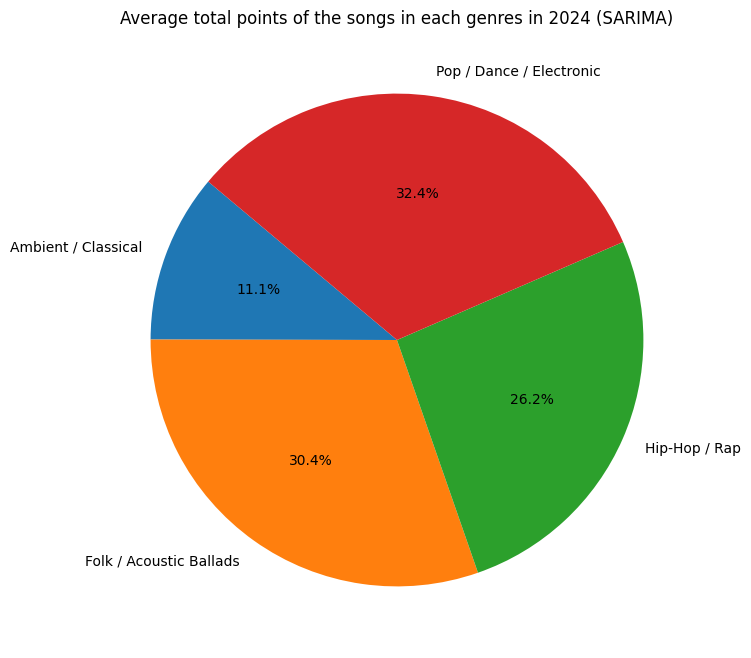

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX


sarima_predictions = {}


for genre in monthly_data['Predicted_Genre'].unique():
    genre_data = monthly_data[monthly_data['Predicted_Genre'] == genre].set_index('YearMonth')
    genre_data = genre_data.asfreq('MS').fillna(0)  # Clearly define the time frequency and fill in missing values

    time_series = genre_data['Points (Total)']
    exog_data = genre_data[feature_columns + ['Month', 'Quarter', 'Year']]

    # Check and process exog data
    if exog_data.isnull().values.any() or np.isinf(exog_data.values).any():
        print(f"Genre {genre} contains invalid values in exog_data. Filling missing values...")
        exog_data = exog_data.fillna(0)

    # Divide the training set and testing set
    train_end = -12
    train = time_series[:train_end]
    test = time_series[train_end:]
    train_exog = exog_data[:train_end]
    test_exog = exog_data[train_end:]

    # Ensure that there are no missing values for exogenous variables in the training and testing sets
    train_exog = train_exog.fillna(0)
    test_exog = test_exog.fillna(0)

    # SARIMA model
    model = SARIMAX(train, exog=train_exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                    enforce_stationarity=False, enforce_invertibility=False)
    fit = model.fit(maxiter=500, disp=False)

    # Test forecast
    test_forecast = fit.forecast(steps=len(test), exog=test_exog)
    test_forecast = np.clip(test_forecast, 0, None)  # Crop the negative score to 0

    # Construct exogenous variables for the next 12 months
    future_dates = pd.date_range(start='2023-05-01', periods=13, freq='MS')[1:]
    future_exog = pd.DataFrame(
        np.tile(exog_data.iloc[-1].values, (12, 1)),
        columns=exog_data.columns,
        index=future_dates
    )
    future_forecast = fit.forecast(steps=12, exog=future_exog)
    future_forecast = np.clip(future_forecast, 0, None)  # Crop the negative score to 0

    # Save the test set and future prediction results
    sarima_predictions[genre] = {
        'test_actual': test.values,
        'test_forecast': test_forecast.values,
        'future_forecast': pd.DataFrame({
            'YearMonth': future_dates,
            'Forecasted_Points': future_forecast.values,
            'Predicted_Genre': genre
        })
    }

    # Visualization results
    plt.figure(figsize=(12, 8))
    plt.plot(train.index, train, label="Training Data", color='blue')
    plt.plot(test.index, test, label="Test Data (Actual)", color='orange')
    plt.plot(test.index, test_forecast, label="Test Predictions", linestyle='--', color='green')
    plt.plot(future_dates, future_forecast, label="Future Predictions (2024)", linestyle='-', color='red')
    plt.title(f"SARIMA Predictions for Genre {genre}")
    plt.xlabel("YearMonth")
    plt.ylabel("Total Points")
    plt.legend()
    plt.grid()
    plt.show()

# Summarize the predicted results of all genres
forecast_df = pd.concat([pred['future_forecast'] for pred in sarima_predictions.values()], ignore_index=True)


#forecast_df.to_csv("sarima_genre_forecast_2024.csv", index=False)

# Summarize the total score of each genre in 2024
total_2024_scores = forecast_df.groupby('Predicted_Genre')['Forecasted_Points'].sum()

# Print the results
print("2024年各流派的总得分：")
print(total_2024_scores)

# Visualizing 2024 total scores for each genre using a pie chart
plt.figure(figsize=(8, 8))
total_2024_scores.plot.pie(autopct='%1.1f%%', startangle=140, labels=total_2024_scores.index)
plt.title('Average total points of the songs in each genres in 2024 (SARIMA)')
plt.ylabel('')  # Remove default y-axis label for cleaner visualization
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Store evaluation indicators
sarima_evaluation_results = {}

for genre, predictions in sarima_predictions.items():
    # Extract test set and predicted values
    test_actual = monthly_data[monthly_data['Predicted_Genre'] == genre].iloc[-12:]['Points (Total)'].values
    test_forecast = predictions['test_forecast']  # Delete .values

    # Handle zero values to avoid MAPE calculation errors
    test_actual = np.where(test_actual == 0, 1e-5, test_actual)

    # Calculate evaluation indicators
    mae = mean_absolute_error(test_actual, test_forecast)
    rmse = np.sqrt(mean_squared_error(test_actual, test_forecast))
    mape = np.mean(np.abs((test_actual - test_forecast) / test_actual)) * 100

    # Print results
    print(f"Evaluation for Genre {genre}:")
    print(f"  - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  - Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  - Mean Absolute Percentage Error (MAPE): {mape:.2f}%\n")

    # Save to result dictionary
    sarima_evaluation_results[genre] = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }


Evaluation for Genre Ambient / Classical:
  - Mean Absolute Error (MAE): 40.8362
  - Root Mean Squared Error (RMSE): 44.9707
  - Mean Absolute Percentage Error (MAPE): 50.70%

Evaluation for Genre Folk / Acoustic Ballads:
  - Mean Absolute Error (MAE): 6.8387
  - Root Mean Squared Error (RMSE): 8.0462
  - Mean Absolute Percentage Error (MAPE): 6.95%

Evaluation for Genre Hip-Hop / Rap:
  - Mean Absolute Error (MAE): 6.6676
  - Root Mean Squared Error (RMSE): 7.3345
  - Mean Absolute Percentage Error (MAPE): 6.53%

Evaluation for Genre Pop / Dance / Electronic:
  - Mean Absolute Error (MAE): 2.6019
  - Root Mean Squared Error (RMSE): 2.9984
  - Mean Absolute Percentage Error (MAPE): 2.58%



LSTM

Columns in monthly_data: Index(['Predicted_Genre', 'YearMonth', 'Points (Total)', 'Danceability',
       'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Valence', 'Month', 'Quarter', 'Year'],
      dtype='object')
Columns in genre_data for Genre Ambient / Classical: Index(['Predicted_Genre', 'YearMonth', 'Points (Total)', 'Danceability',
       'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Valence', 'Month', 'Quarter', 'Year'],
      dtype='object')
Epoch 1/150


c:\Users\86137\anaconda3\envs\pytorch\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.2666 - val_loss: 0.1419 - learning_rate: 5.0000e-04
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1869 - val_loss: 0.1377 - learning_rate: 5.0000e-04
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1435 - val_loss: 0.1322 - learning_rate: 5.0000e-04
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1365 - val_loss: 0.1250 - learning_rate: 5.0000e-04
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0827 - val_loss: 0.1177 - learning_rate: 5.0000e-04
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0821 - val_loss: 0.1115 - learning_rate: 5.0000e-04
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0667 - val_loss: 0.1056 - learning_rate: 5.0000e-04
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0537 - val_loss: 0.1012 - learning_rate: 5.0000e-04
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0579 - val_loss: 0.0974 - learning_rate: 5.0000e-04
Epoch 

C:\Users\86137\AppData\Local\Temp\ipykernel_2420\1889398456.py:100: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=test_data['YearMonth'].iloc[-1], periods=13, freq='M')[1:], future_predictions_actual, label="Future Predictions", linestyle='-', color='red')


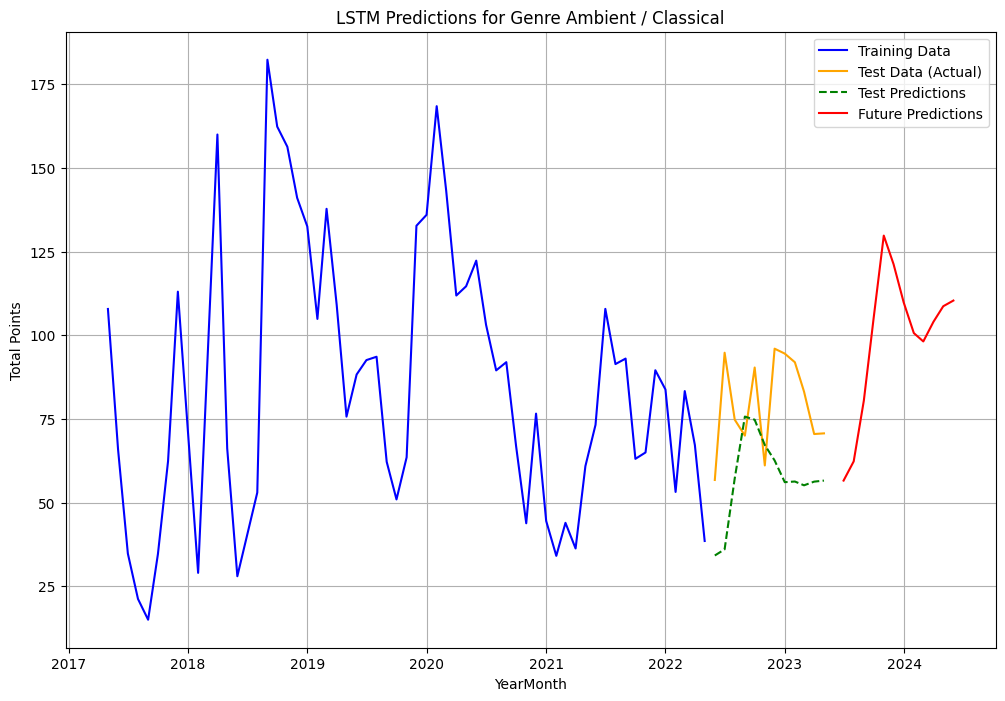

Columns in genre_data for Genre Folk / Acoustic Ballads: Index(['Predicted_Genre', 'YearMonth', 'Points (Total)', 'Danceability',
       'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Valence', 'Month', 'Quarter', 'Year'],
      dtype='object')
Epoch 1/150


C:\Users\86137\AppData\Local\Temp\ipykernel_2420\1889398456.py:110: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'YearMonth': pd.date_range(start=test_data['YearMonth'].iloc[-1], periods=13, freq='M')[1:],
c:\Users\86137\anaconda3\envs\pytorch\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.3146 - val_loss: 0.3969 - learning_rate: 5.0000e-04
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1988 - val_loss: 0.3894 - learning_rate: 5.0000e-04
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1308 - val_loss: 0.3832 - learning_rate: 5.0000e-04
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0890 - val_loss: 0.3778 - learning_rate: 5.0000e-04
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0674 - val_loss: 0.3704 - learning_rate: 5.0000e-04
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0553 - val_loss: 0.3577 - learning_rate: 5.0000e-04
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0470 - val_loss: 0.3444 - learning_rate: 5.0000e-04
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0488 - val_loss: 0.3376 - learning_rate: 5.0000e-04
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0468 - val_loss: 0.3316 - learning_rate: 5.0000e-04
Epoch 

C:\Users\86137\AppData\Local\Temp\ipykernel_2420\1889398456.py:100: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=test_data['YearMonth'].iloc[-1], periods=13, freq='M')[1:], future_predictions_actual, label="Future Predictions", linestyle='-', color='red')


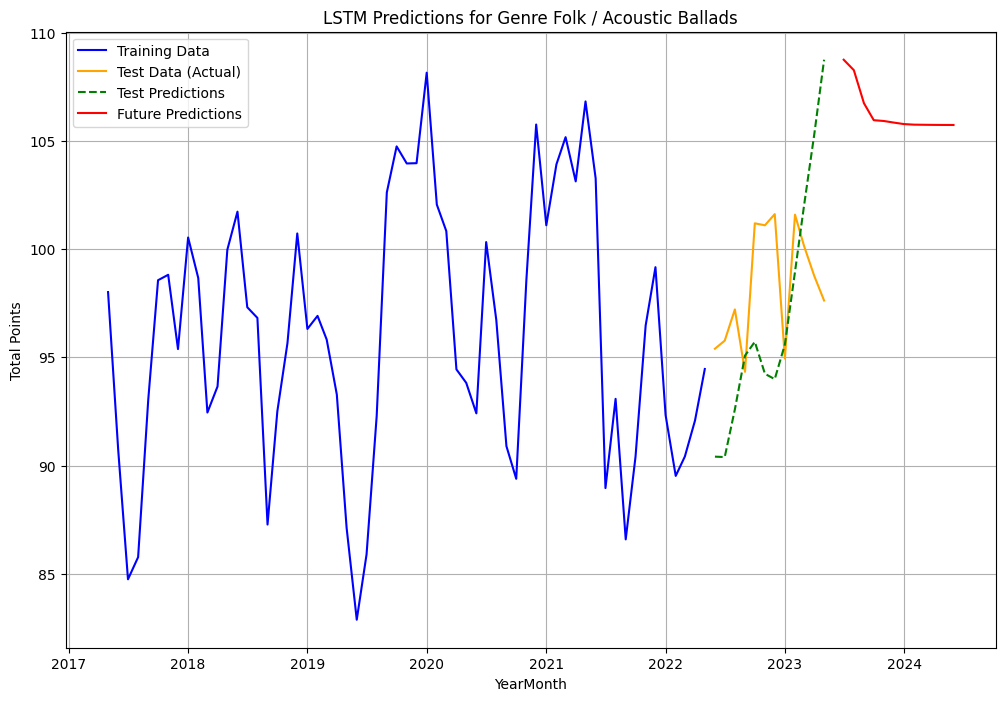

Columns in genre_data for Genre Hip-Hop / Rap: Index(['Predicted_Genre', 'YearMonth', 'Points (Total)', 'Danceability',
       'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Valence', 'Month', 'Quarter', 'Year'],
      dtype='object')
Epoch 1/150


C:\Users\86137\AppData\Local\Temp\ipykernel_2420\1889398456.py:110: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'YearMonth': pd.date_range(start=test_data['YearMonth'].iloc[-1], periods=13, freq='M')[1:],
c:\Users\86137\anaconda3\envs\pytorch\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.5024 - val_loss: 0.5166 - learning_rate: 5.0000e-04
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3319 - val_loss: 0.5158 - learning_rate: 5.0000e-04
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2112 - val_loss: 0.5158 - learning_rate: 5.0000e-04
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1562 - val_loss: 0.5140 - learning_rate: 5.0000e-04
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0909 - val_loss: 0.5030 - learning_rate: 5.0000e-04
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0593 - val_loss: 0.4857 - learning_rate: 5.0000e-04
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0673 - val_loss: 0.4660 - learning_rate: 5.0000e-04
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0455 - val_loss: 0.4420 - learning_rate: 5.0000e-04
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0372 - val_loss: 0.4224 - learning_rate: 5.0000e-04
Epoch 10/

C:\Users\86137\AppData\Local\Temp\ipykernel_2420\1889398456.py:100: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=test_data['YearMonth'].iloc[-1], periods=13, freq='M')[1:], future_predictions_actual, label="Future Predictions", linestyle='-', color='red')


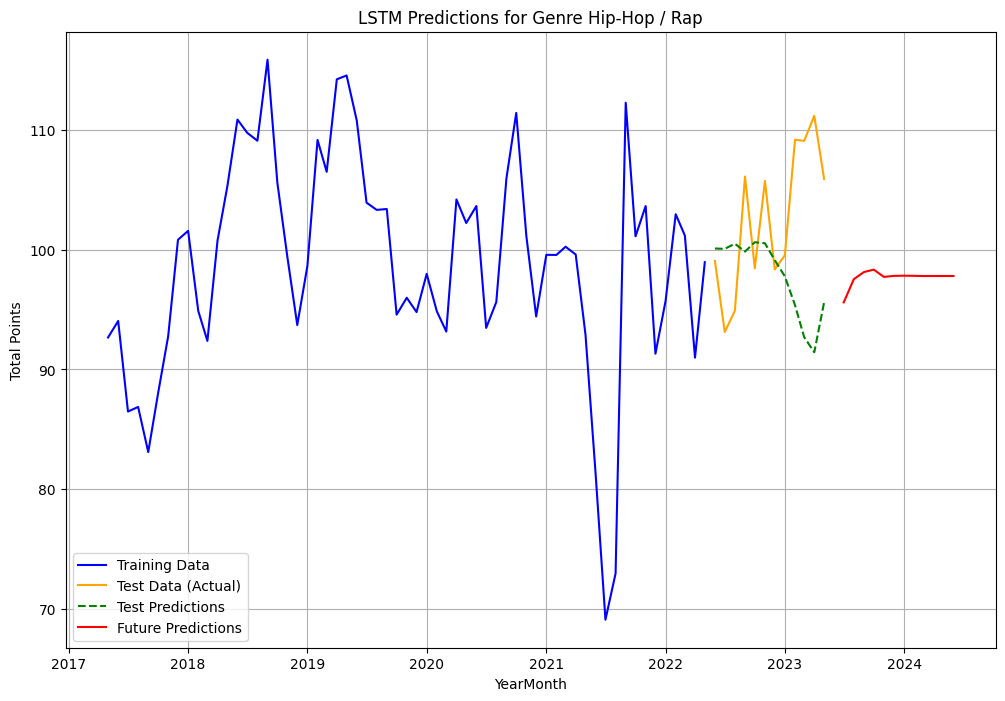

Columns in genre_data for Genre Pop / Dance / Electronic: Index(['Predicted_Genre', 'YearMonth', 'Points (Total)', 'Danceability',
       'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Valence', 'Month', 'Quarter', 'Year'],
      dtype='object')
Epoch 1/150


C:\Users\86137\AppData\Local\Temp\ipykernel_2420\1889398456.py:110: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'YearMonth': pd.date_range(start=test_data['YearMonth'].iloc[-1], periods=13, freq='M')[1:],
c:\Users\86137\anaconda3\envs\pytorch\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.1841 - val_loss: 0.0744 - learning_rate: 5.0000e-04
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1150 - val_loss: 0.0714 - learning_rate: 5.0000e-04
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0730 - val_loss: 0.0670 - learning_rate: 5.0000e-04
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0563 - val_loss: 0.0622 - learning_rate: 5.0000e-04
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0346 - val_loss: 0.0577 - learning_rate: 5.0000e-04
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0382 - val_loss: 0.0533 - learning_rate: 5.0000e-04
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0365 - val_loss: 0.0499 - learning_rate: 5.0000e-04
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0298 - val_loss: 0.0479 - learning_rate: 5.0000e-04
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0255 - val_loss: 0.0463 - learning_rate: 5.0000e-04
Epoch

C:\Users\86137\AppData\Local\Temp\ipykernel_2420\1889398456.py:100: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=test_data['YearMonth'].iloc[-1], periods=13, freq='M')[1:], future_predictions_actual, label="Future Predictions", linestyle='-', color='red')


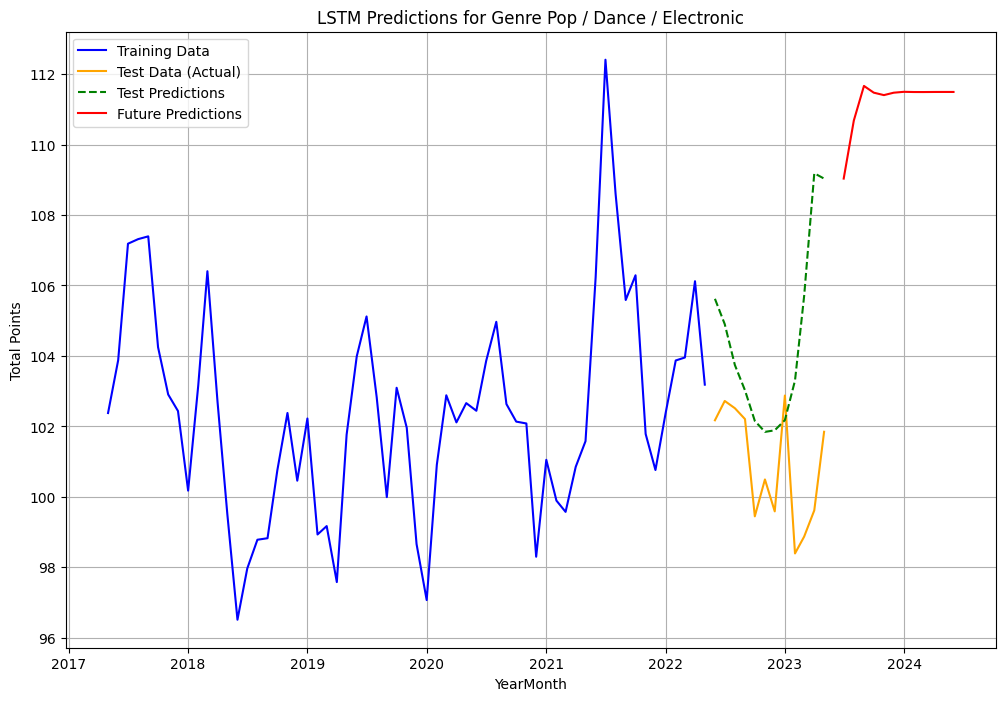

2024年各流派的总得分：
Predicted_Genre
Ambient / Classical         1187.271484
Folk / Acoustic Ballads     1275.975708
Hip-Hop / Rap               1171.857544
Pop / Dance / Electronic    1334.680786
Name: Forecasted_Points, dtype: float32


C:\Users\86137\AppData\Local\Temp\ipykernel_2420\1889398456.py:110: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'YearMonth': pd.date_range(start=test_data['YearMonth'].iloc[-1], periods=13, freq='M')[1:],


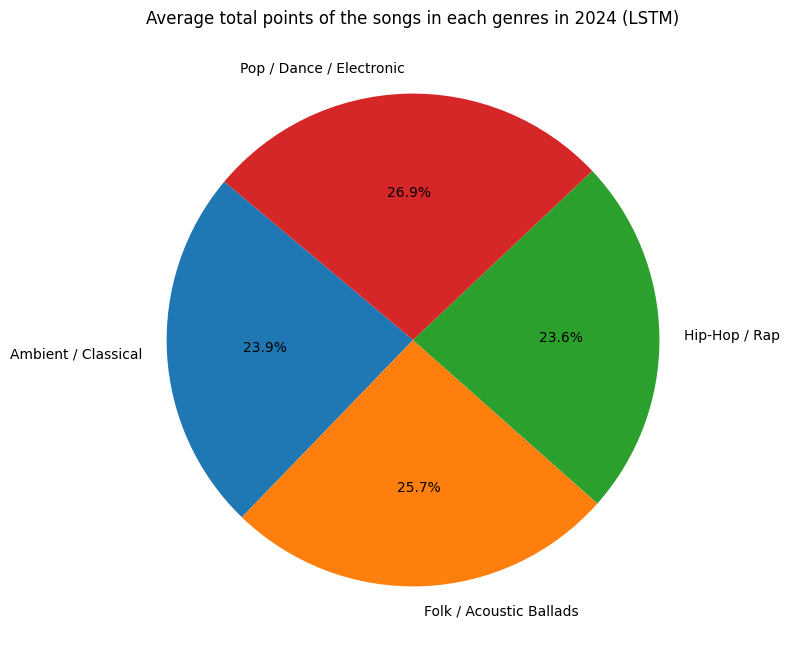

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


print("Columns in monthly_data:", monthly_data.columns)

# Initialize LSTM prediction result storage
lstm_predictions = {}

# Traverse the time series data of each genre
for genre in monthly_data['Predicted_Genre'].unique():
    # Extract time series data of the current genre
    genre_data = monthly_data[monthly_data['Predicted_Genre'] == genre].reset_index(drop=True)

    # Verify whether the data is complete
    print(f"Columns in genre_data for Genre {genre}:", genre_data.columns)

    # Input feature list
    input_features = feature_columns + ['Month', 'Quarter', 'Year']

    # Ensure that these columns exist in the dataset
    missing_features = [col for col in input_features if col not in genre_data.columns]
    if missing_features:
        raise KeyError(f"Missing features in genre_data: {missing_features}")

    # Obtain the starting point for the last 12 months
    last_12_months_start = genre_data['YearMonth'].iloc[-12]

    # Divide the training set and testing set
    train_data = genre_data[genre_data['YearMonth'] < last_12_months_start]
    test_data = genre_data[genre_data['YearMonth'] >= last_12_months_start]

    # Data standardization
    feature_scaler = MinMaxScaler()
    score_scaler = MinMaxScaler()
    scaled_features = feature_scaler.fit_transform(genre_data[input_features])
    scaled_scores = score_scaler.fit_transform(genre_data[['Points (Total)']])
    scaled_data = np.hstack((scaled_features, scaled_scores))

    # Create LSTM dataset
    def create_lstm_dataset(data, timesteps):
        X, y = [], []
        for i in range(len(data) - timesteps):
            X.append(data[i:i + timesteps, :-1])  
            y.append(data[i + timesteps, -1])    
        return np.array(X), np.array(y)

    timesteps = 4   # Using a 4-month time step
    X, y = create_lstm_dataset(scaled_data, timesteps=timesteps)
    X_train = X[:len(train_data) - timesteps]
    X_test = X[len(train_data) - timesteps:]
    y_train = y[:len(train_data) - timesteps]
    y_test = y[len(train_data) - timesteps:]

    # Build an optimized LSTM model
    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=(timesteps, X_train.shape[2])),
        Dropout(0.3),
        BatchNormalization(),
        LSTM(64, activation='tanh', return_sequences=True),
        Dropout(0.3),
        LSTM(32, activation='tanh'),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

    # Training model
    model.fit(X_train, y_train, epochs=150, batch_size=16, validation_data=(X_test, y_test), verbose=1, callbacks=[reduce_lr])

    # Prediction on test dataset
    y_test_pred = model.predict(X_test)

    # Anti normalization prediction results
    y_test_actual = score_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_test_pred_actual = score_scaler.inverse_transform(y_test_pred).flatten()

    # Future prediction
    last_sequence = X_test[-1]
    future_predictions = []
    for _ in range(12):
        prediction = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
        future_predictions.append(prediction)
        new_input = np.vstack((last_sequence[1:], np.hstack((last_sequence[-1, :-1], prediction)).reshape(1, -1)))
        last_sequence = new_input
    future_predictions_actual = score_scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

    # Plot the results
    plt.figure(figsize=(12, 8))
    plt.plot(train_data['YearMonth'][timesteps:], score_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten(), label="Training Data", color='blue')
    plt.plot(test_data['YearMonth'], y_test_actual, label="Test Data (Actual)", color='orange')
    plt.plot(test_data['YearMonth'], y_test_pred_actual, label="Test Predictions", linestyle='--', color='green')
    plt.plot(pd.date_range(start=test_data['YearMonth'].iloc[-1], periods=13, freq='M')[1:], future_predictions_actual, label="Future Predictions", linestyle='-', color='red')
    plt.title(f"LSTM Predictions for Genre {genre}")
    plt.xlabel("YearMonth")
    plt.ylabel("Total Points")
    plt.legend()
    plt.grid()
    plt.show()

    # Save prediction results
    genre_forecast = pd.DataFrame({
        'YearMonth': pd.date_range(start=test_data['YearMonth'].iloc[-1], periods=13, freq='M')[1:],
        'Forecasted_Points': future_predictions_actual,
        'Predicted_Genre': genre
    })
    lstm_predictions[genre] = genre_forecast

# Summarize future predictions
forecast_df = pd.concat(lstm_predictions.values(), ignore_index=True)


# Summarize the total score of each genre in 2024
total_2024_scores = forecast_df.groupby('Predicted_Genre')['Forecasted_Points'].sum()
print("2024年各流派的总得分：")
print(total_2024_scores)
# Visualizing 2024 total scores for each genre using a pie chart
plt.figure(figsize=(8, 8))
total_2024_scores.plot.pie(autopct='%1.1f%%', startangle=140, labels=total_2024_scores.index)
plt.title('Average total points of the songs in each genres in 2024 (LSTM)')
plt.ylabel('')  # Remove default y-axis label for cleaner visualization
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Storage evaluation indicators
lstm_evaluation_results = {}

for genre, forecast in lstm_predictions.items():
    # Extract actual and predicted values from the test set
    test_data = monthly_data[(monthly_data['Predicted_Genre'] == genre) & (monthly_data['YearMonth'] >= last_12_months_start)]
    y_test_actual = test_data['Points (Total)'].values
    y_test_pred_actual = forecast.loc[:11, 'Forecasted_Points'].values  # 前 12 个时间步预测值

    # Calculate evaluation indicators
    mae = mean_absolute_error(y_test_actual, y_test_pred_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_actual))
    mape = np.mean(np.abs((y_test_actual - y_test_pred_actual) / y_test_actual)) * 100

    # Print the results
    print(f"Evaluation for Genre {genre}:")
    print(f"  - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  - Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  - Mean Absolute Percentage Error (MAPE): {mape:.2f}%\n")
    
    # Save to result dictionary
    lstm_evaluation_results[genre] = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }


Evaluation for Genre Ambient / Classical:
  - Mean Absolute Error (MAE): 24.8276
  - Root Mean Squared Error (RMSE): 30.5865
  - Mean Absolute Percentage Error (MAPE): 33.12%

Evaluation for Genre Folk / Acoustic Ballads:
  - Mean Absolute Error (MAE): 8.0256
  - Root Mean Squared Error (RMSE): 8.6738
  - Mean Absolute Percentage Error (MAPE): 8.26%

Evaluation for Genre Hip-Hop / Rap:
  - Mean Absolute Error (MAE): 6.1492
  - Root Mean Squared Error (RMSE): 7.4625
  - Mean Absolute Percentage Error (MAPE): 5.82%

Evaluation for Genre Pop / Dance / Electronic:
  - Mean Absolute Error (MAE): 10.3267
  - Root Mean Squared Error (RMSE): 10.5045
  - Mean Absolute Percentage Error (MAPE): 10.27%



In [ ]:
# Compare and evaluate the results
comparison_results = pd.DataFrame({
    'Genre': sarima_evaluation_results.keys(),
    'SARIMA_MAE': [sarima_evaluation_results[genre]['MAE'] for genre in sarima_evaluation_results],
    'LSTM_MAE': [lstm_evaluation_results[genre]['MAE'] for genre in lstm_evaluation_results],
    'SARIMA_RMSE': [sarima_evaluation_results[genre]['RMSE'] for genre in sarima_evaluation_results],
    'LSTM_RMSE': [lstm_evaluation_results[genre]['RMSE'] for genre in lstm_evaluation_results],
    'SARIMA_MAPE': [sarima_evaluation_results[genre]['MAPE'] for genre in sarima_evaluation_results],
    'LSTM_MAPE': [lstm_evaluation_results[genre]['MAPE'] for genre in lstm_evaluation_results],
})

# Print comparison results
print("Model Comparison Results:")
print(comparison_results)


Model Comparison Results:
                      Genre  SARIMA_MAE   LSTM_MAE  SARIMA_RMSE  LSTM_RMSE  \
0       Ambient / Classical   40.836211  24.827611    44.970674  30.586486   
1   Folk / Acoustic Ballads    6.838664   8.025636     8.046217   8.673762   
2             Hip-Hop / Rap    6.667561   6.149233     7.334550   7.462476   
3  Pop / Dance / Electronic    2.601872  10.326748     2.998373  10.504517   

   SARIMA_MAPE  LSTM_MAPE  
0    50.695550  33.119656  
1     6.950031   8.257585  
2     6.528360   5.816764  
3     2.578151  10.265697  
